# Jinlun Zhang

Data Dictionary

Customer_id: the customer's unique identifier

Age: the customer's age

Location: the country the customer lives in

Device: the device the customer uses (Android or iOS)

And 12 months of data related to:
- their monthly spend (i.e., the total amount the customer spent in a month)

- the number of items purchased in the month

- the number of support calls placed in the month (i.e., how many times they called customer service)

This data represents customers who churned last month, but have had at least 12 months of transactions previously. 

### The Main Question: which factors can help us predict if a customer will churn?


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from scipy import stats
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, precision_recall_curve
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
%matplotlib inline
from statsmodels.formula.api import ols


In [70]:
# assume the data is stored in the local directory
df = pd.read_csv('churn_data.csv')
df

,Unnamed: 0,CustomerID,Age,Location,Device,Month_1_Spend,Month_1_Items,Month_1_Support_Calls,Month_2_Spend,Month_2_Items,...,Month_10_Spend,Month_10_Items,Month_10_Support_Calls,Month_11_Spend,Month_11_Items,Month_11_Support_Calls,Month_12_Spend,Month_12_Items,Month_12_Support_Calls,Churn
0,0,1,46,US,iOS,756.005761,39,2,582.023075,92,...,280.397827,60,0,700.181510,66,3,382.719682,59,0,1
1,1,2,52,US,iOS,594.838157,59,0,251.269898,33,...,863.000645,89,1,571.331352,28,3,570.203975,89,0,1
2,2,3,43,Canada,Android,453.217405,21,3,124.178946,92,...,858.545990,60,5,198.222684,38,1,187.475764,79,5,1
3,3,4,41,US,iOS,621.453170,95,1,134.362559,46,...,404.590146,59,3,565.395592,78,1,281.415092,63,4,1
4,4,5,41,US,iOS,660.735119,48,5,713.265527,54,...,178.143438,85,1,574.382094,34,2,544.981985,28,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,9996,35,Great Britain,iOS,496.165324,84,1,735.148231,60,...,708.936256,77,4,672.755957,23,5,710.675753,60,4,0
9996,9996,9997,59,Great Britain,iOS,138.836616,76,3,673.599667,52,...,736.393247,57,4,379.113761,75,4,870.230372,15,3,0
9997,9997,9998,45,US,iOS,533.289217,106,4,367.139990,41,...,567.421148,50,3,633.113010,89,5,624.403650,35,4,0
9998,9998,9999,58,Australia,iOS,684.746137,70,0,751.149320,105,...,239.675846,32,5,103.703552,97,5,731.775049,28,4,0


In [6]:
# Quick Inspection
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 42 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              10000 non-null  int64  
 1   CustomerID              10000 non-null  int64  
 2   Age                     10000 non-null  int64  
 3   Location                10000 non-null  object 
 4   Device                  10000 non-null  object 
 5   Month_1_Spend           10000 non-null  float64
 6   Month_1_Items           10000 non-null  int64  
 7   Month_1_Support_Calls   10000 non-null  int64  
 8   Month_2_Spend           10000 non-null  float64
 9   Month_2_Items           10000 non-null  int64  
 10  Month_2_Support_Calls   10000 non-null  int64  
 11  Month_3_Spend           10000 non-null  float64
 12  Month_3_Items           10000 non-null  int64  
 13  Month_3_Support_Calls   10000 non-null  int64  
 14  Month_4_Spend           10000 non-null 

In [7]:
df.describe()

,Unnamed: 0,CustomerID,Age,Month_1_Spend,Month_1_Items,Month_1_Support_Calls,Month_2_Spend,Month_2_Items,Month_2_Support_Calls,Month_3_Spend,...,Month_10_Spend,Month_10_Items,Month_10_Support_Calls,Month_11_Spend,Month_11_Items,Month_11_Support_Calls,Month_12_Spend,Month_12_Items,Month_12_Support_Calls,Churn
count,10000.00000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,4999.50000,5000.50000,42.698500,482.593336,64.657700,2.488800,476.297118,63.118000,2.517400,481.965314,...,473.630524,58.227900,2.487000,472.671126,56.968900,2.519500,478.629330,56.512600,2.496300,0.70000
std,2886.89568,2886.89568,12.495528,237.961476,29.329527,1.711306,237.491820,28.933247,1.703639,235.535388,...,235.090366,25.909251,1.721083,234.288930,25.615119,1.702266,233.135282,25.263995,1.713674,0.45828
min,0.00000,1.00000,20.000000,45.147050,12.000000,0.000000,46.283232,12.000000,0.000000,45.792390,...,45.784922,12.000000,0.000000,45.139863,12.000000,0.000000,45.093583,12.000000,0.000000,0.00000
25%,2499.75000,2500.75000,32.000000,275.978779,39.000000,1.000000,268.427326,38.000000,1.000000,283.141582,...,268.470286,36.000000,1.000000,269.432095,35.000000,1.000000,276.507055,35.000000,1.000000,0.00000
50%,4999.50000,5000.50000,43.000000,482.173250,65.000000,2.000000,474.442784,63.000000,3.000000,480.440066,...,472.391691,58.000000,2.000000,472.530676,57.000000,3.000000,481.872558,56.000000,3.000000,1.00000
75%,7499.25000,7500.25000,53.000000,688.898992,90.000000,4.000000,680.824377,88.000000,4.000000,684.508894,...,680.923305,80.000000,4.000000,673.599392,78.000000,4.000000,681.397961,77.000000,4.000000,1.00000
max,9999.00000,10000.00000,65.000000,889.597940,115.000000,5.000000,889.712540,113.000000,5.000000,889.756303,...,889.979951,113.000000,5.000000,889.998913,113.000000,5.000000,889.612221,113.000000,5.000000,1.00000


### First Observation
The data mainly consists of numeric variables (only 2 categorical variables), and a subset of the variables tend to be 'time-series' (as they describe the monthly user spend, items, and support calls across a year), implying that some statistical testing and feature engineering techniques (like feature aggregation and PCA) can be adopted to reduce the dimensionality of the data to avoid problems like dimensionality explosion and over-sparse dataset


The columns 'Unnamed: 0' and 'CustomerID' are not important to the following process as they just represent the indices of the records, so we can simply drop out them here

In [71]:
df.drop(['Unnamed: 0','CustomerID'], axis=1, inplace=True)

# EDA
The target variable is: Churn -> If the customer churned last month or not
State your hypothesis based on the insights from your exploration.

In [ ]:
# fastest way to get all relational plots to find the features needed for investigations

# UNCOMMENT BELOW LINE TO REPLICATE THE RESULT (THIS LINE IS COMMENTED OUT AS IT TAKES MORE THAN 10 MINS TO RUN)
#sns.pairplot(df, hue='Churn')



As shown above, the graph is very long and complicated due to the high dimensionality the dataset has, while the data distributions of 'monthly features' like the 'monthly spend' and 'monthly support calls' are similar across different monthes, which may suggests that we should check if those monthly features can be combined to 'yearly' or 'half-year' features to avoid the curse of dimensionality

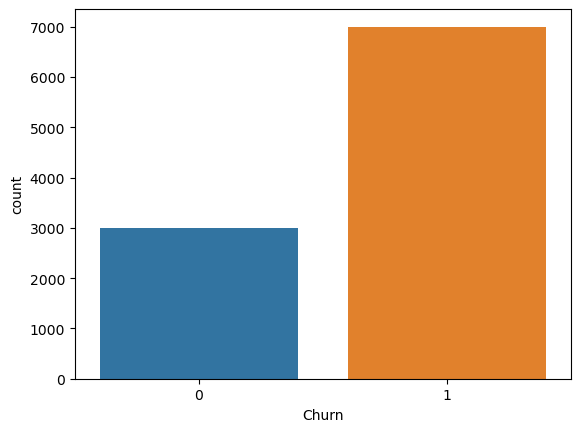

In [11]:
# Display the distribution of the target variable 'Churn'
sns.countplot(x='Churn', data=df)
plt.show()


As shown by the distribution of the target variable 'Churn', this target variable is quite imbalanced (the number of records with churn = 1 is nearly twice of the number of records with churn = 0). This implies that we should not primarily rely on the accuracy score to solve this classification problem (i.e. not using accuracy as a scoring function during the model training) as the accuracy cannot tell if the model actually captures the underlying patterns in the dataset or simply being biased towards the majority class. Thus, the evaluation metric selected for the later model selection and model training should include f1 score and roc_auc_score as well to yield better insights to the model performance.

In addition, the imbalanced data may also suggest that it is plasuible to use resampling methods for this task like under-sampling (reduces the number of instances from the over-represented classes to be equal to the number of minority class instances) or over-sampling (Bootstrapping more minority instances to the under-represented classes)


Let check the correlations of the features to see if there is any signficant linear relationships between features

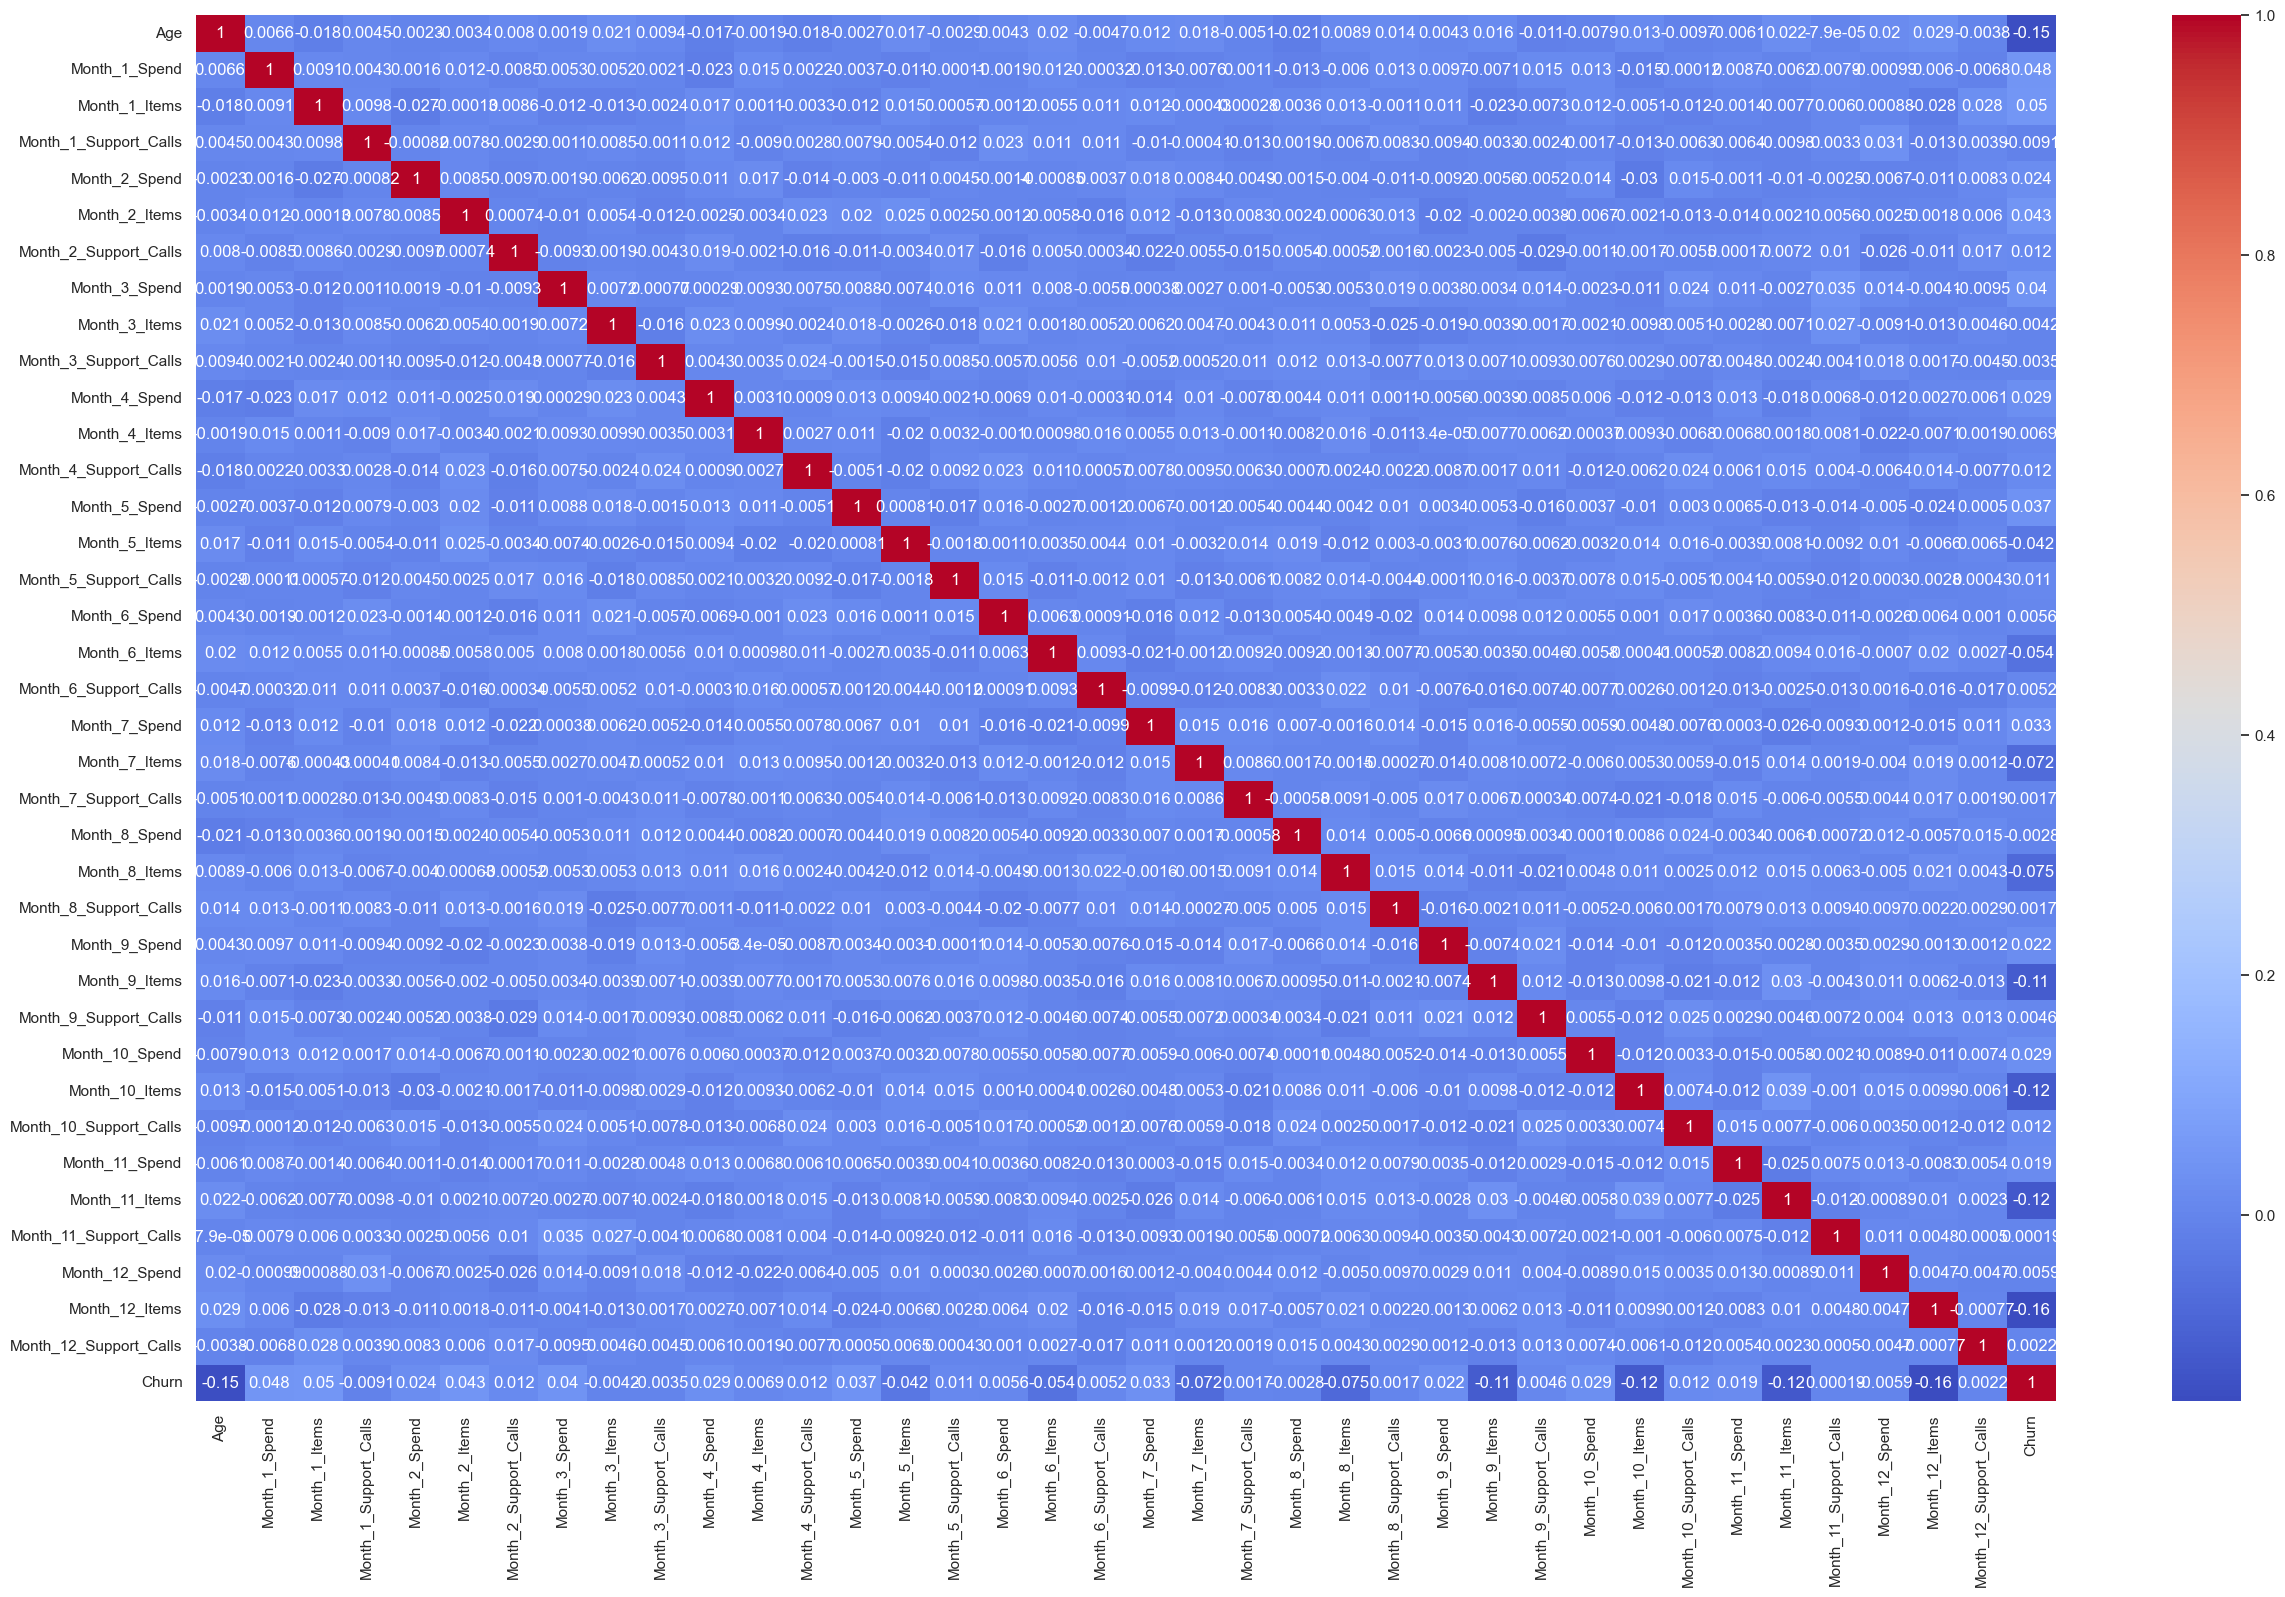

In [13]:
# Correlation matrix heatmap
sns.set(rc={'figure.figsize':(30,18)})
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

Interestingly, the feature 'age' is somehow moderately negatively correlated with the target variable 'churn' comparing to other features (-0.15), while 'monthly features' like 'Month_9_Items' (-0.11), 'Month_10_Items' (-0.12), 'Month_11_Items' (-0.12), and 'Month_12_Items' (-0.16) also display similar negative correlations. This may suggest that we can investigate those features further as those non-negligible negative relationships suggest that the users who buy more items in those months (month 9 to month 12) are less likely to churn

ON the other hand, all the 'monthly features' do not show significant linear retionships between each other, implying that we should conduct statistical testing for those features 

<Axes: xlabel='Churn', ylabel='Month_12_Spend'>

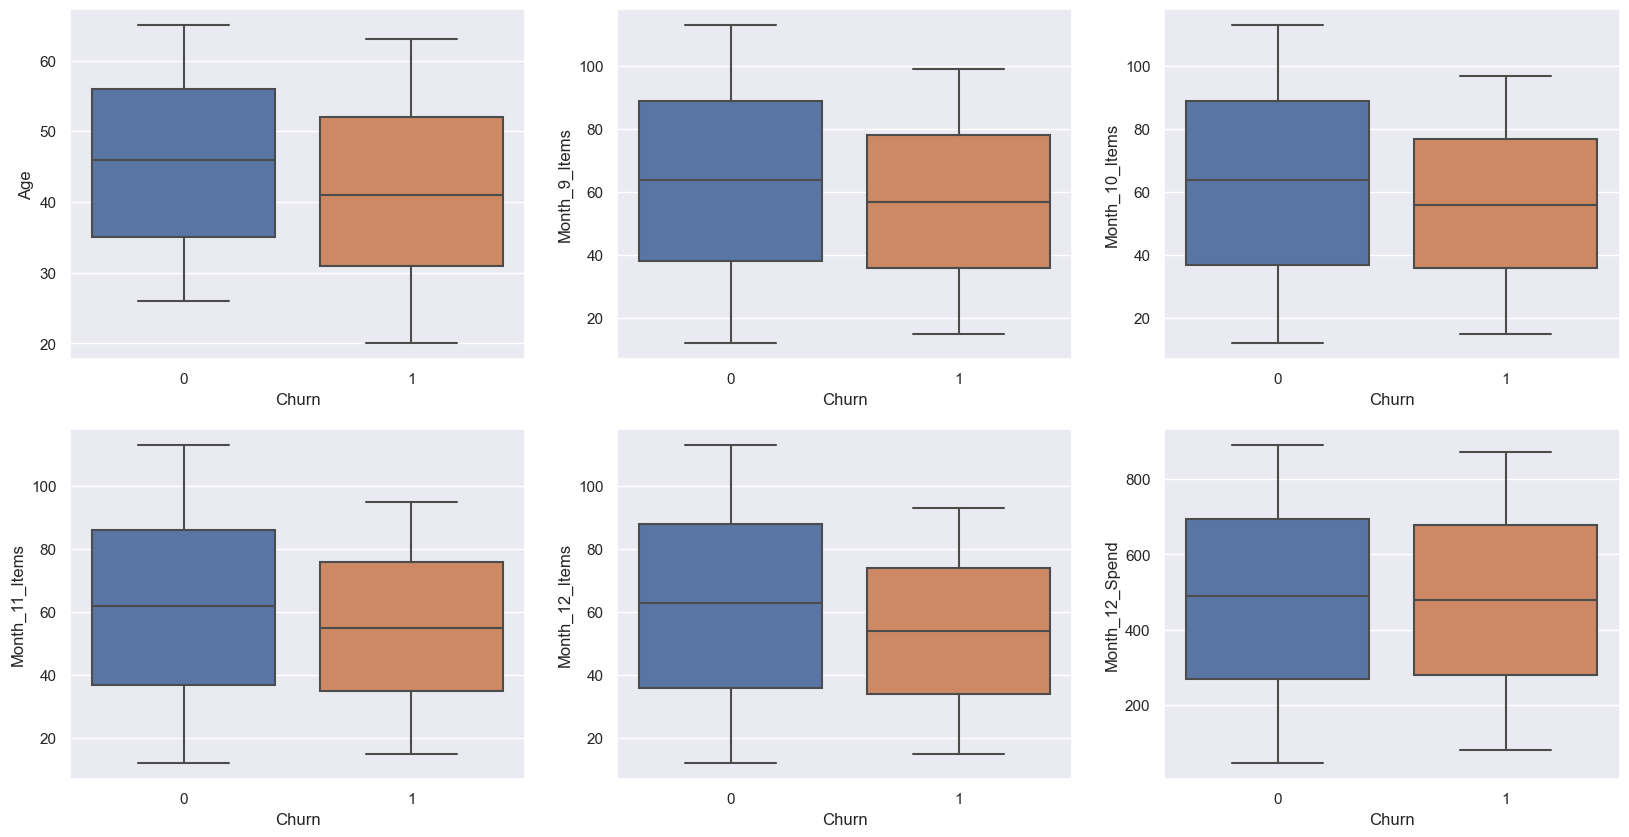

In [17]:
# create 6 subplots for 6 continuous variables

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3, figsize=(20,10))

sns.boxplot(x='Churn', y='Age', ax=ax1, data=df)
sns.boxplot(x='Churn', y='Month_9_Items', ax=ax2, data=df)
sns.boxplot(x='Churn', y='Month_10_Items', ax=ax3, data=df) 
sns.boxplot(x='Churn', y='Month_11_Items', ax=ax4, data=df)
sns.boxplot(x='Churn', y='Month_12_Items', ax=ax5, data=df)
sns.boxplot(x='Churn', y='Month_12_Spend', ax=ax6, data=df)

As we can see, no outliers are detected in those boxplots, indicating that those features do not have some extreme feature values within. Also, the 'age' boxplot indicates that the people who churned last month tend to be younger (median around 40 comparing to the median of 45 of people who did not churn). This indicates that the 'age' feature can be an informative feature for the model training, and it also suggests that our items are more appealing to the older people (in other words, people who are older than 35 but less than 55 are our main loyal customers as this is the interquartile range of age of people who did not churn)

From monthly item boxplots, we can see that the people who did not churn tend to purchase more items (indicated by the larger IQR it has) comparing to the people who churned, supporting our previous conclusion that the users who buy more items in those months (month 9 to month 12) are less likely to churn. However, those monthly item boxplots are quite similar to each other (with nearly the same scale), implying that we can combine those features together rather than analyzing them one by one later

For the last box plot, which shows the month 12 spend, the users who churned or did not churned have about the same spending, suggesting that the 'spend' may not be a informative feature for the model training. We can investigate the spend more on below. 

However, before proceeding to the statistical testing of the monthly data, we need to investiagte if the user behaviours are not affected by certain characteristics. This means that users 'Location' and 'Device' shouldn't correlate with if they are churned last month or not

Month_2_Spend       total percent_Android percent_iOS
Device       Android   iOS                                  
Churn                                                       
0                896  2104  3000        0.298667    0.701333
1               4840  2160  7000        0.691429    0.308571

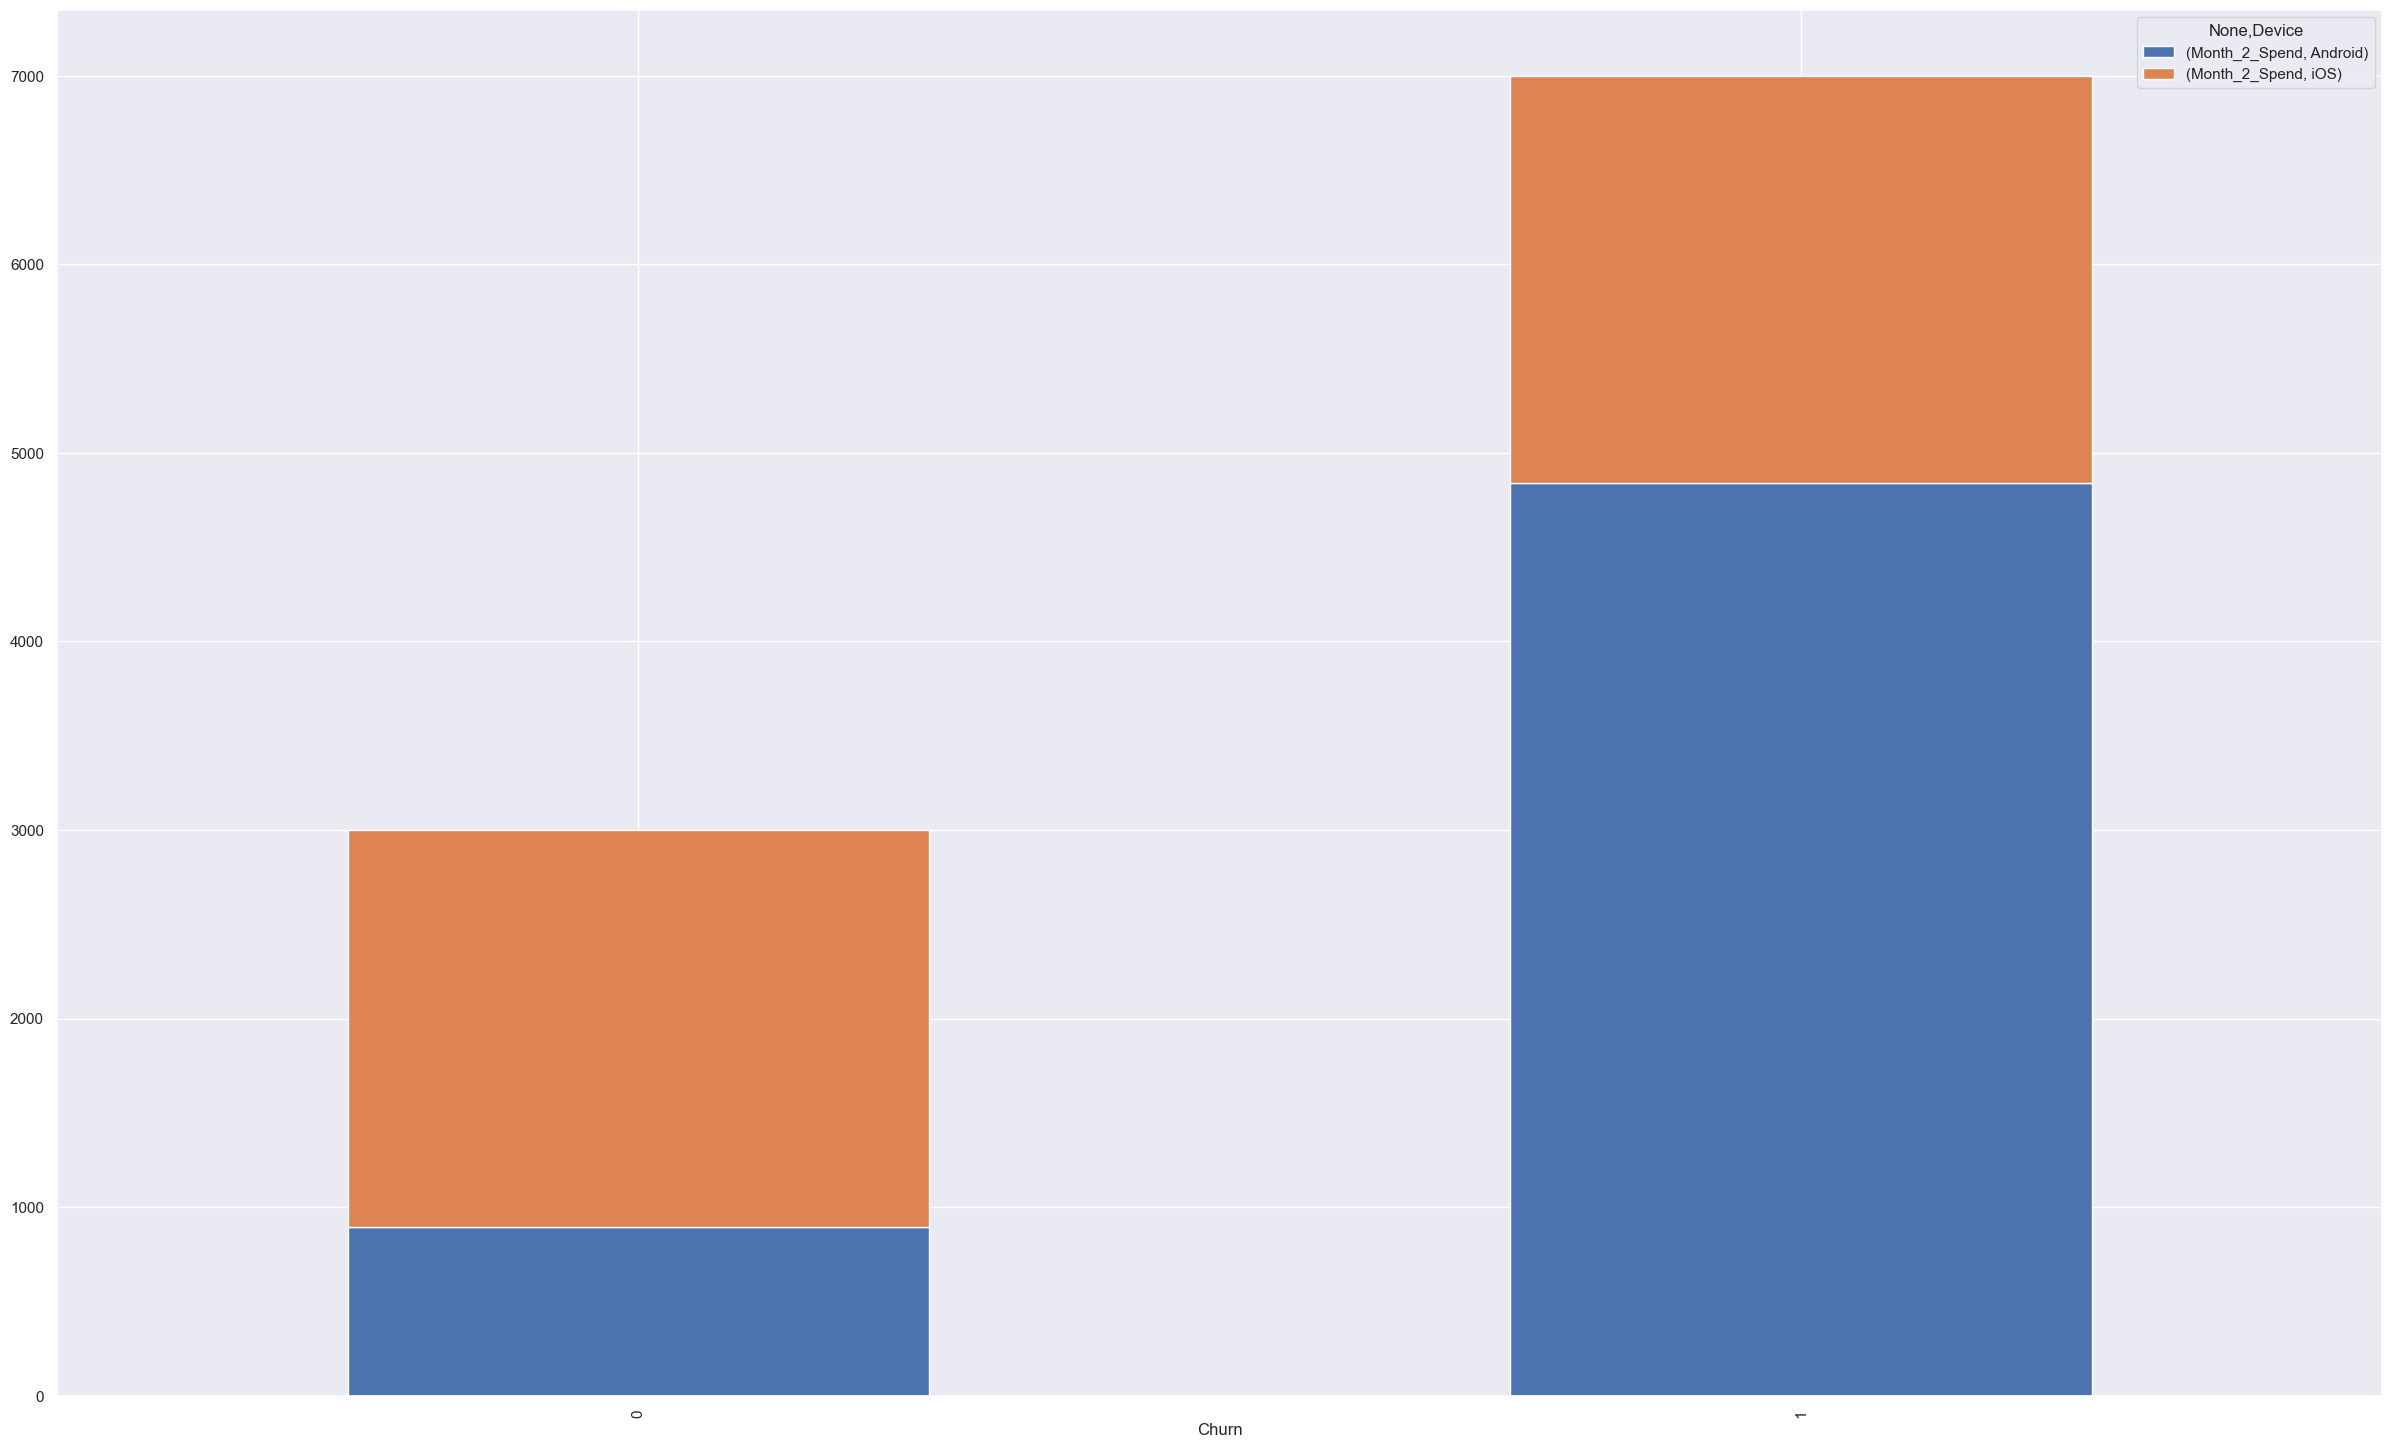

In [30]:
device = df.groupby(['Churn','Device'])[['Month_2_Spend']].count().unstack()
device['total'] = device['Month_2_Spend']['Android'] + device['Month_2_Spend']['iOS']
device['percent_Android'] = device['Month_2_Spend']['Android'] / device['total']
device['percent_iOS'] = device['Month_2_Spend']['iOS'] / device['total']
df.groupby(['Churn','Device'])[['Month_2_Spend']].count().unstack().plot(kind='bar', stacked=True)
device

As shown above, we can see that the users' device is related with the target variable 'churn'. The people who are using Android are very likely to churn last month (among all churned customers, nearly 70% of them are using Android), while the people who are using iOS, conversely, are more likely to stay loyal (among all non-churned customers, nearly 70% of them are using iOS). 

### This is an important insight, because the different churn rates on different user platforms may means that our apps are not optimized (i.e. not intuitive and user-friendly) for the Android users (i.e. slow app performance or long response time).

Moreover, this different churn rate cannot be attributed to the fact that the iOS users tend to be younger, because the difference between the median of ages of the churned and non-churn groups is only 5. Hence, the technical team, collaborated with the marketing team, have to investigate more on the Android platform to either improve the app on the Android platform according to the user feedback or launch promotional campaigns to increase Android customer's loyality specifically

On the other hand, this feature can be one-hot encoded to be used as one of the informative features to train a model to predict the customer churn 

Now let's how the location relates with the churn

Month_2_Spend           total percent_0 percent_1
Churn                     0       1                            
Location                                                       
Australia             725.0     NaN     NaN       NaN       NaN
Canada                763.0  3495.0  4258.0  0.179192  0.820808
Great Britain         762.0     NaN     NaN       NaN       NaN
US                    750.0  3505.0  4255.0  0.176263  0.823737

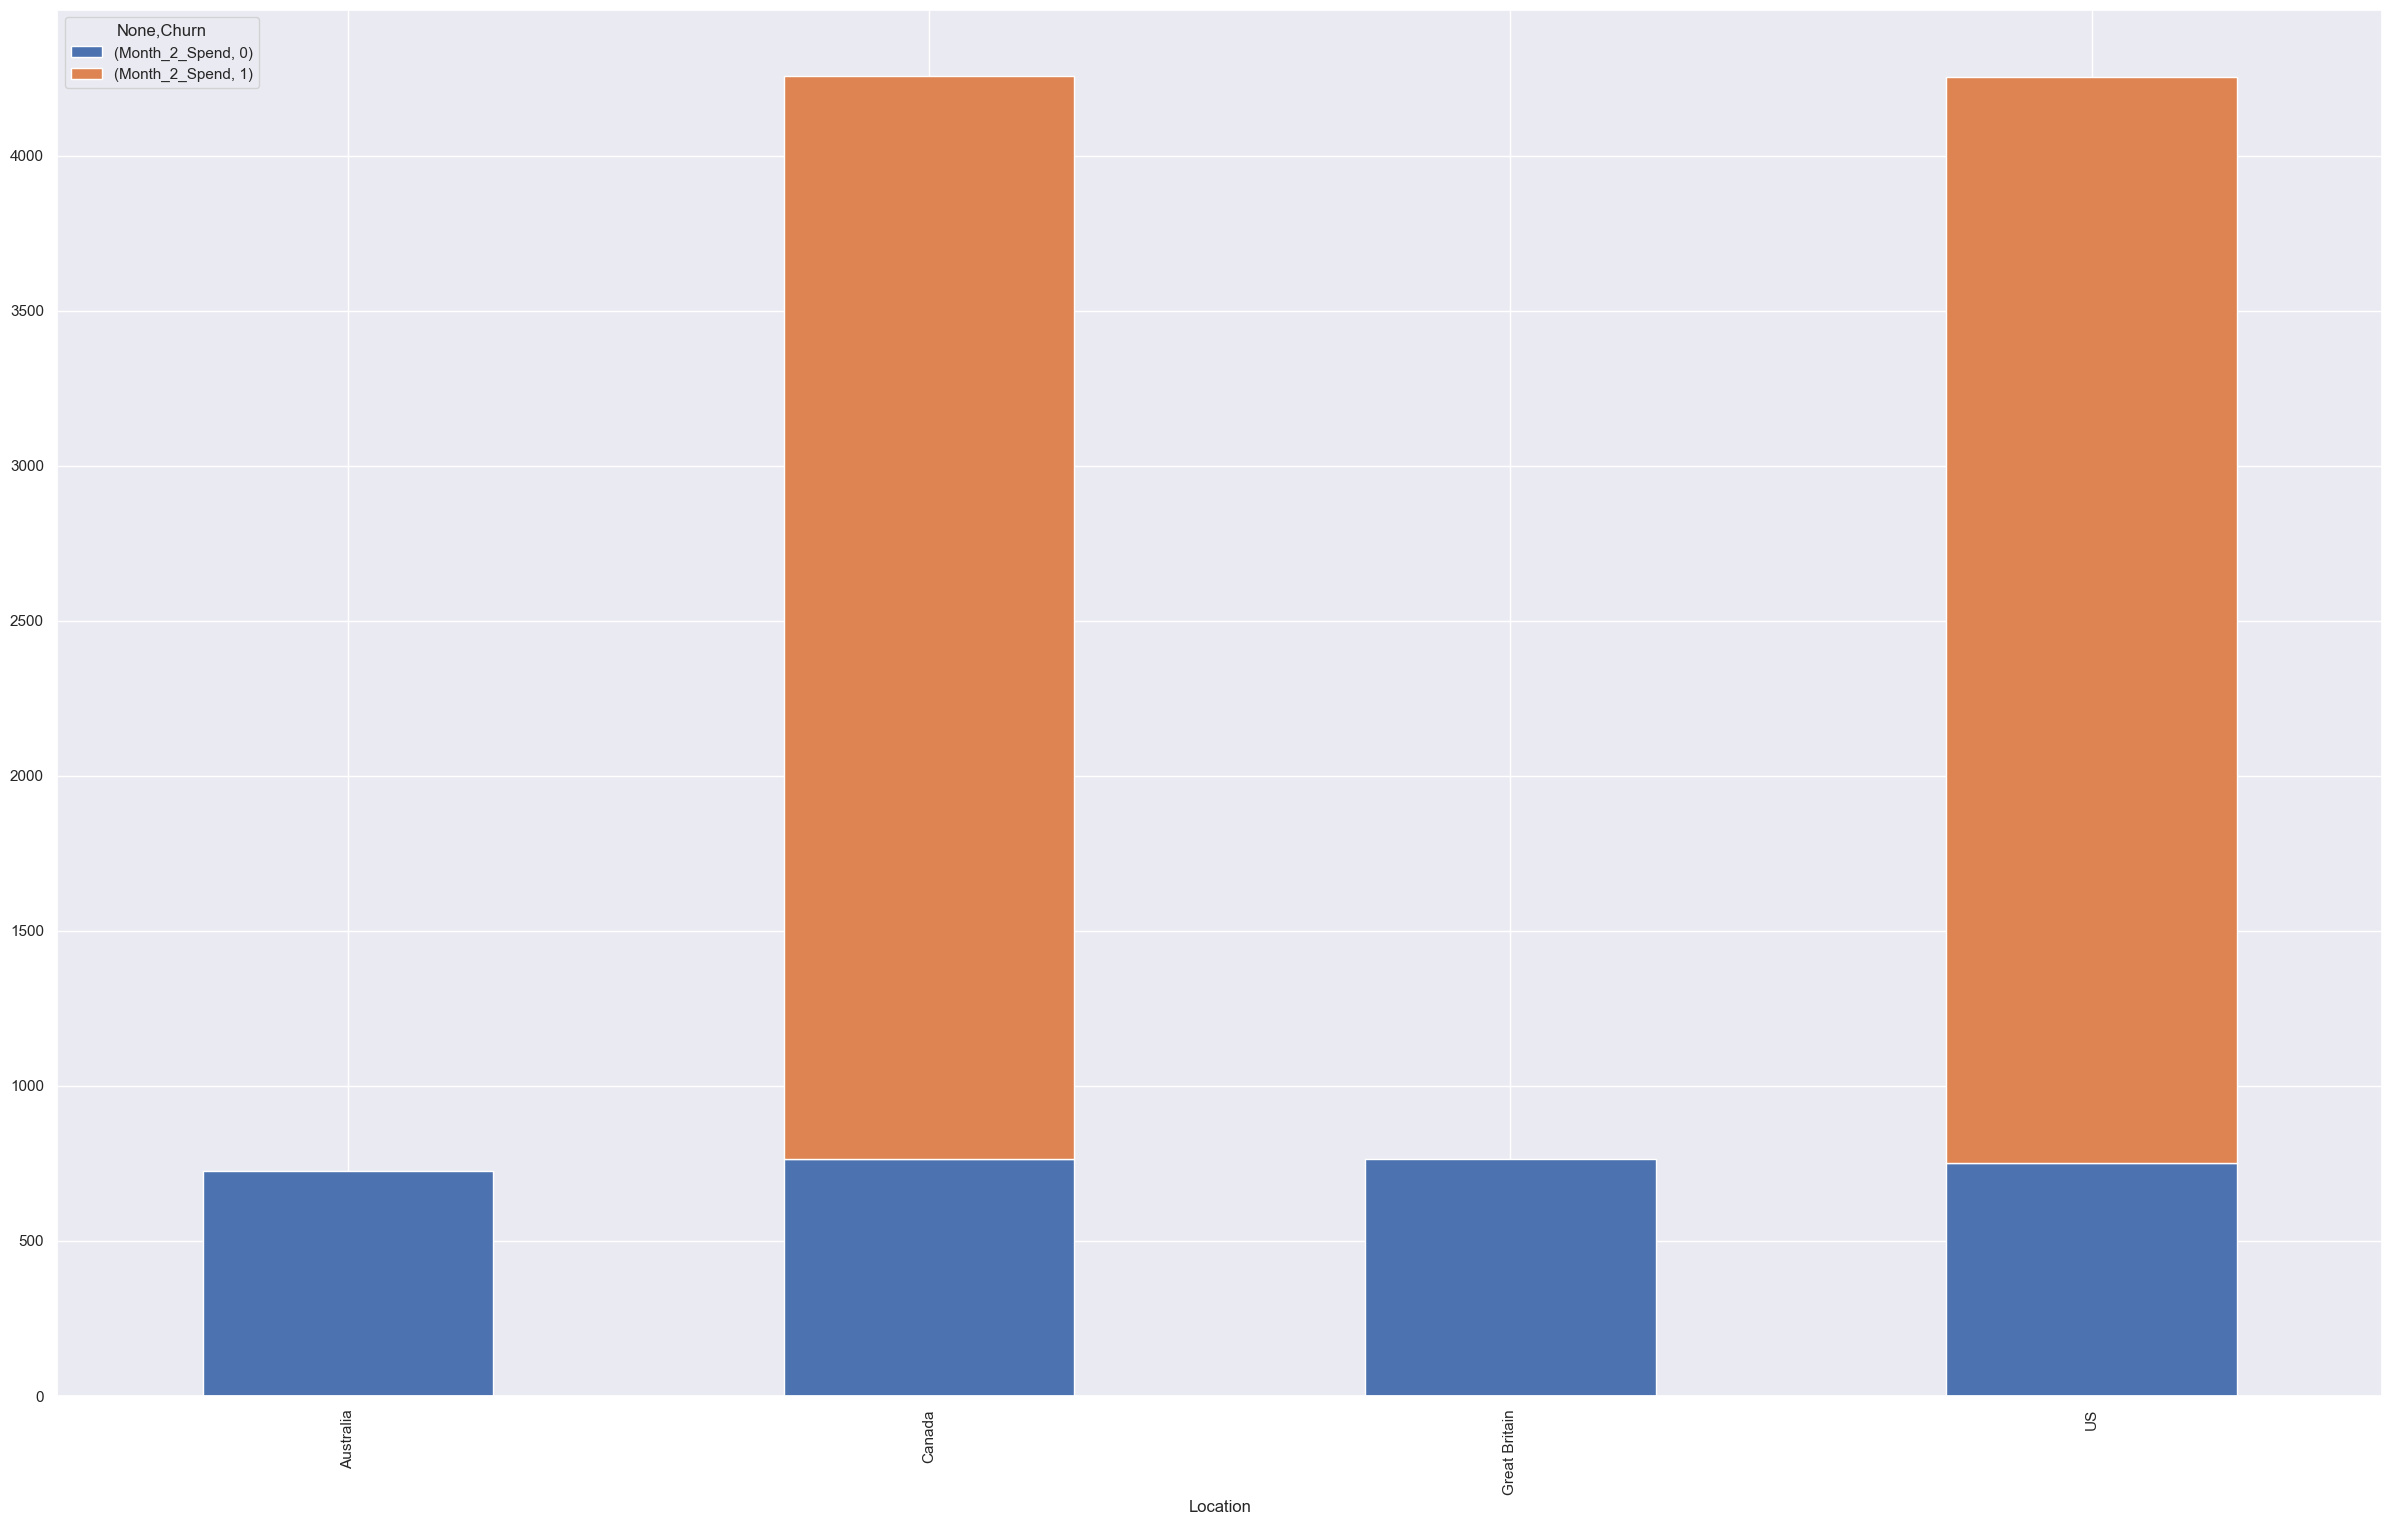

In [34]:
location = df.groupby(['Location','Churn'])[['Month_2_Spend']].count().unstack()
location['total'] = location['Month_2_Spend'][0] + location['Month_2_Spend'][1]
location['percent_0'] = location['Month_2_Spend'][0] / location['total']
location['percent_1'] = location['Month_2_Spend'][1] / location['total']
df.groupby(['Location','Churn'])[['Month_2_Spend']].count().unstack().plot(kind='bar', stacked=True)
location

### What happen to our North America market ?
While none of our Australia and Great Britain customers have churned, nearly 80% of our North America (US and Canada) customers have churned. Was there a scandal of our company or app last month? Why majority of our North America customers churned ? Is there a way to re-activate them ? Those are the questions for the marketing department and the business executives

On the technical side, I plan to convert this categorical variable into a binary categorical feature called 'in_north_america' to combine these sparse data points into meaningful groups, which removes redundancies (no churn customers in Australia or UK), while potentially increasing the statistical power of some ML models. However, it is still noteworthy that the result feature, 'in_north_america', is still quite imbalanced as we have more customers in north america, leading to potential overfitting of the model (model is biased towards the dominant category). We should be mindful with this

*I complete the feature engineering within the EDA section for a quick result and save time*

In [72]:
mapping = {'Australia':0, 'Great Britain':0, 'Canada':1, 'US':1}
df['in_north_america'] = df['Location'].map(mapping)
df.drop(['Location'], axis=1, inplace=True)
df

,Age,Device,Month_1_Spend,Month_1_Items,Month_1_Support_Calls,Month_2_Spend,Month_2_Items,Month_2_Support_Calls,Month_3_Spend,Month_3_Items,...,Month_10_Items,Month_10_Support_Calls,Month_11_Spend,Month_11_Items,Month_11_Support_Calls,Month_12_Spend,Month_12_Items,Month_12_Support_Calls,Churn,in_north_america
0,46,iOS,756.005761,39,2,582.023075,92,2,212.323540,96,...,60,0,700.181510,66,3,382.719682,59,0,1,1
1,52,iOS,594.838157,59,0,251.269898,33,2,186.909752,63,...,89,1,571.331352,28,3,570.203975,89,0,1,1
2,43,Android,453.217405,21,3,124.178946,92,0,316.492407,40,...,60,5,198.222684,38,1,187.475764,79,5,1,1
3,41,iOS,621.453170,95,1,134.362559,46,5,162.945529,65,...,59,3,565.395592,78,1,281.415092,63,4,1,1
4,41,iOS,660.735119,48,5,713.265527,54,2,736.904463,69,...,85,1,574.382094,34,2,544.981985,28,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,35,iOS,496.165324,84,1,735.148231,60,2,656.082890,105,...,77,4,672.755957,23,5,710.675753,60,4,0,0
9996,59,iOS,138.836616,76,3,673.599667,52,4,665.929803,61,...,57,4,379.113761,75,4,870.230372,15,3,0,0
9997,45,iOS,533.289217,106,4,367.139990,41,1,249.490470,112,...,50,3,633.113010,89,5,624.403650,35,4,0,1
9998,58,iOS,684.746137,70,0,751.149320,105,4,860.697594,109,...,32,5,103.703552,97,5,731.775049,28,4,0,0


In [73]:
mapping = {'Android':0, 'iOS':1}
df['Device'] = df['Device'].map(mapping)
df

,Age,Device,Month_1_Spend,Month_1_Items,Month_1_Support_Calls,Month_2_Spend,Month_2_Items,Month_2_Support_Calls,Month_3_Spend,Month_3_Items,...,Month_10_Items,Month_10_Support_Calls,Month_11_Spend,Month_11_Items,Month_11_Support_Calls,Month_12_Spend,Month_12_Items,Month_12_Support_Calls,Churn,in_north_america
0,46,1,756.005761,39,2,582.023075,92,2,212.323540,96,...,60,0,700.181510,66,3,382.719682,59,0,1,1
1,52,1,594.838157,59,0,251.269898,33,2,186.909752,63,...,89,1,571.331352,28,3,570.203975,89,0,1,1
2,43,0,453.217405,21,3,124.178946,92,0,316.492407,40,...,60,5,198.222684,38,1,187.475764,79,5,1,1
3,41,1,621.453170,95,1,134.362559,46,5,162.945529,65,...,59,3,565.395592,78,1,281.415092,63,4,1,1
4,41,1,660.735119,48,5,713.265527,54,2,736.904463,69,...,85,1,574.382094,34,2,544.981985,28,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,35,1,496.165324,84,1,735.148231,60,2,656.082890,105,...,77,4,672.755957,23,5,710.675753,60,4,0,0
9996,59,1,138.836616,76,3,673.599667,52,4,665.929803,61,...,57,4,379.113761,75,4,870.230372,15,3,0,0
9997,45,1,533.289217,106,4,367.139990,41,1,249.490470,112,...,50,3,633.113010,89,5,624.403650,35,4,0,1
9998,58,1,684.746137,70,0,751.149320,105,4,860.697594,109,...,32,5,103.703552,97,5,731.775049,28,4,0,0


Now all features should be numeric

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     10000 non-null  int64  
 1   Device                  10000 non-null  int64  
 2   Month_1_Spend           10000 non-null  float64
 3   Month_1_Items           10000 non-null  int64  
 4   Month_1_Support_Calls   10000 non-null  int64  
 5   Month_2_Spend           10000 non-null  float64
 6   Month_2_Items           10000 non-null  int64  
 7   Month_2_Support_Calls   10000 non-null  int64  
 8   Month_3_Spend           10000 non-null  float64
 9   Month_3_Items           10000 non-null  int64  
 10  Month_3_Support_Calls   10000 non-null  int64  
 11  Month_4_Spend           10000 non-null  float64
 12  Month_4_Items           10000 non-null  int64  
 13  Month_4_Support_Calls   10000 non-null  int64  
 14  Month_5_Spend           10000 non-null 

# Data Cleaning

### Remove duplicate data records


In [39]:
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     10000 non-null  int64  
 1   Device                  10000 non-null  int64  
 2   Month_1_Spend           10000 non-null  float64
 3   Month_1_Items           10000 non-null  int64  
 4   Month_1_Support_Calls   10000 non-null  int64  
 5   Month_2_Spend           10000 non-null  float64
 6   Month_2_Items           10000 non-null  int64  
 7   Month_2_Support_Calls   10000 non-null  int64  
 8   Month_3_Spend           10000 non-null  float64
 9   Month_3_Items           10000 non-null  int64  
 10  Month_3_Support_Calls   10000 non-null  int64  
 11  Month_4_Spend           10000 non-null  float64
 12  Month_4_Items           10000 non-null  int64  
 13  Month_4_Support_Calls   10000 non-null  int64  
 14  Month_5_Spend           10000 non-null 

Check Missing value

No missing value detected

In [41]:
# Plot the missing value count as a bar chart

missing = df.isnull().sum()
print(missing)


Age                       0
Device                    0
Month_1_Spend             0
Month_1_Items             0
Month_1_Support_Calls     0
Month_2_Spend             0
Month_2_Items             0
Month_2_Support_Calls     0
Month_3_Spend             0
Month_3_Items             0
Month_3_Support_Calls     0
Month_4_Spend             0
Month_4_Items             0
Month_4_Support_Calls     0
Month_5_Spend             0
Month_5_Items             0
Month_5_Support_Calls     0
Month_6_Spend             0
Month_6_Items             0
Month_6_Support_Calls     0
Month_7_Spend             0
Month_7_Items             0
Month_7_Support_Calls     0
Month_8_Spend             0
Month_8_Items             0
Month_8_Support_Calls     0
Month_9_Spend             0
Month_9_Items             0
Month_9_Support_Calls     0
Month_10_Spend            0
Month_10_Items            0
Month_10_Support_Calls    0
Month_11_Spend            0
Month_11_Items            0
Month_11_Support_Calls    0
Month_12_Spend      

# Statistical Testing & Experimentation

In [45]:
month_spend = ['Month_1_Spend', 'Month_2_Spend','Month_3_Spend','Month_4_Spend',
               'Month_5_Spend','Month_6_Spend','Month_7_Spend','Month_8_Spend', 
               'Month_9_Spend','Month_10_Spend','Month_11_Spend','Month_12_Spend']

month_item = ['Month_1_Items', 'Month_2_Items','Month_3_Items','Month_4_Items',
               'Month_5_Items','Month_6_Items','Month_7_Items','Month_8_Items', 
               'Month_9_Items','Month_10_Items','Month_11_Items','Month_12_Items']

month_call = ['Month_1_Support_Calls', 'Month_2_Support_Calls','Month_3_Support_Calls','Month_4_Support_Calls',
               'Month_5_Support_Calls','Month_6_Support_Calls','Month_7_Support_Calls','Month_8_Support_Calls', 
               'Month_9_Support_Calls','Month_10_Support_Calls','Month_11_Support_Calls','Month_12_Support_Calls']


In [56]:
# check if month spend is about the same across months
spend = []
for i in month_spend:
    spend.append(df[i])
    
p_val = stats.f_oneway(*spend)
print("p-value of spend aross months: ", p_val[1])

p-value of spend aross months:  0.06330799654114602


Since p value is slightly larger than 0.05, we can conclude that the monthly spend is about the same across months in this year, meaning that we can aggregate all the spend in one column or 2 (average yearly spend and maximal yearly spend)

In [74]:
df['yearly_average_spend'] = df[month_spend].mean(axis=1)
df['yearly_max_spend'] = df[month_spend].max(axis=1)
df.drop(month_spend, axis=1, inplace=True)
df

,Age,Device,Month_1_Items,Month_1_Support_Calls,Month_2_Items,Month_2_Support_Calls,Month_3_Items,Month_3_Support_Calls,Month_4_Items,Month_4_Support_Calls,...,Month_10_Items,Month_10_Support_Calls,Month_11_Items,Month_11_Support_Calls,Month_12_Items,Month_12_Support_Calls,Churn,in_north_america,yearly_average_spend,yearly_max_spend
0,46,1,39,2,92,2,96,4,93,3,...,60,0,66,3,59,0,1,1,568.983464,845.591428
1,52,1,59,0,33,2,63,4,34,0,...,89,1,28,3,89,0,1,1,446.081453,863.000645
2,43,0,21,3,92,0,40,5,99,1,...,60,5,38,1,79,5,1,1,422.393677,858.545990
3,41,1,95,1,46,5,65,2,99,0,...,59,3,78,1,63,4,1,1,436.612547,823.619025
4,41,1,48,5,54,2,69,1,65,1,...,85,1,34,2,28,2,1,1,460.925228,742.525914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,35,1,84,1,60,2,105,1,50,1,...,77,4,23,5,60,4,0,0,645.911531,827.987050
9996,59,1,76,3,52,4,61,4,26,5,...,57,4,75,4,15,3,0,0,616.485066,870.230372
9997,45,1,106,4,41,1,112,0,44,3,...,50,3,89,5,35,4,0,1,406.938829,633.113010
9998,58,1,70,0,105,4,109,1,47,5,...,32,5,97,5,28,4,0,0,556.979727,860.697594


Check month items

In [61]:
# check if month spend is about the same across months
item = []
for i in month_item:
    item.append(df[i])
    
p_val = stats.f_oneway(*item)
print("p-value of spend aross months: ", p_val[1])

p-value of spend aross months:  1.0385856622508068e-195


Items are different, which correspond to our previous conclusion that the month items are different for month 9 to 12, let's isolate them and check the p value from the ANOVA testing

In [62]:
p_val = stats.f_oneway(item[0],item[1],item[2],item[3],item[4])
print("p-value of spend aross months: ", p_val[1])

p-value of spend aross months:  5.486010093938424e-17


Interesting, item sold per month shows statistically significant differences, meaing that we may not be able to aggregate them, so for now, lets just keep them

Now let check the support calls

In [63]:
# check if month spend is about the same across months
call = []
for i in month_call:
    call.append(df[i])
    
p_val = stats.f_oneway(*call)
print("p-value of spend aross months: ", p_val[1])

p-value of spend aross months:  0.8610849056298955


p-value is much larger than 0.05, meaning that the support calls across different months are about the same, so we can simply take a average of the support calls as a 'yearly support call' feature (the average call is rounded up to preserve some interpretability in the data), ending up with a total number of feature being 19, which is moderately acceptable

In [75]:
df['yearly_average_call'] = df[month_call].mean(axis=1).round() # around the call to get integer to preserve interpretability
df.drop(month_call, axis=1, inplace=True)
df

,Age,Device,Month_1_Items,Month_2_Items,Month_3_Items,Month_4_Items,Month_5_Items,Month_6_Items,Month_7_Items,Month_8_Items,Month_9_Items,Month_10_Items,Month_11_Items,Month_12_Items,Churn,in_north_america,yearly_average_spend,yearly_max_spend,yearly_average_call
0,46,1,39,92,96,93,77,61,29,56,30,60,66,59,1,1,568.983464,845.591428,2.0
1,52,1,59,33,63,34,39,99,51,80,40,89,28,89,1,1,446.081453,863.000645,2.0
2,43,0,21,92,40,99,81,90,68,43,46,60,38,79,1,1,422.393677,858.545990,3.0
3,41,1,95,46,65,99,80,65,39,72,94,59,78,63,1,1,436.612547,823.619025,2.0
4,41,1,48,54,69,65,44,70,34,75,67,85,34,28,1,1,460.925228,742.525914,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,35,1,84,60,105,50,102,90,89,24,92,77,23,60,0,0,645.911531,827.987050,3.0
9996,59,1,76,52,61,26,79,48,88,107,17,57,75,15,0,0,616.485066,870.230372,3.0
9997,45,1,106,41,112,44,86,36,47,39,91,50,89,35,0,1,406.938829,633.113010,3.0
9998,58,1,70,105,109,47,30,94,78,68,98,32,97,28,0,0,556.979727,860.697594,3.0


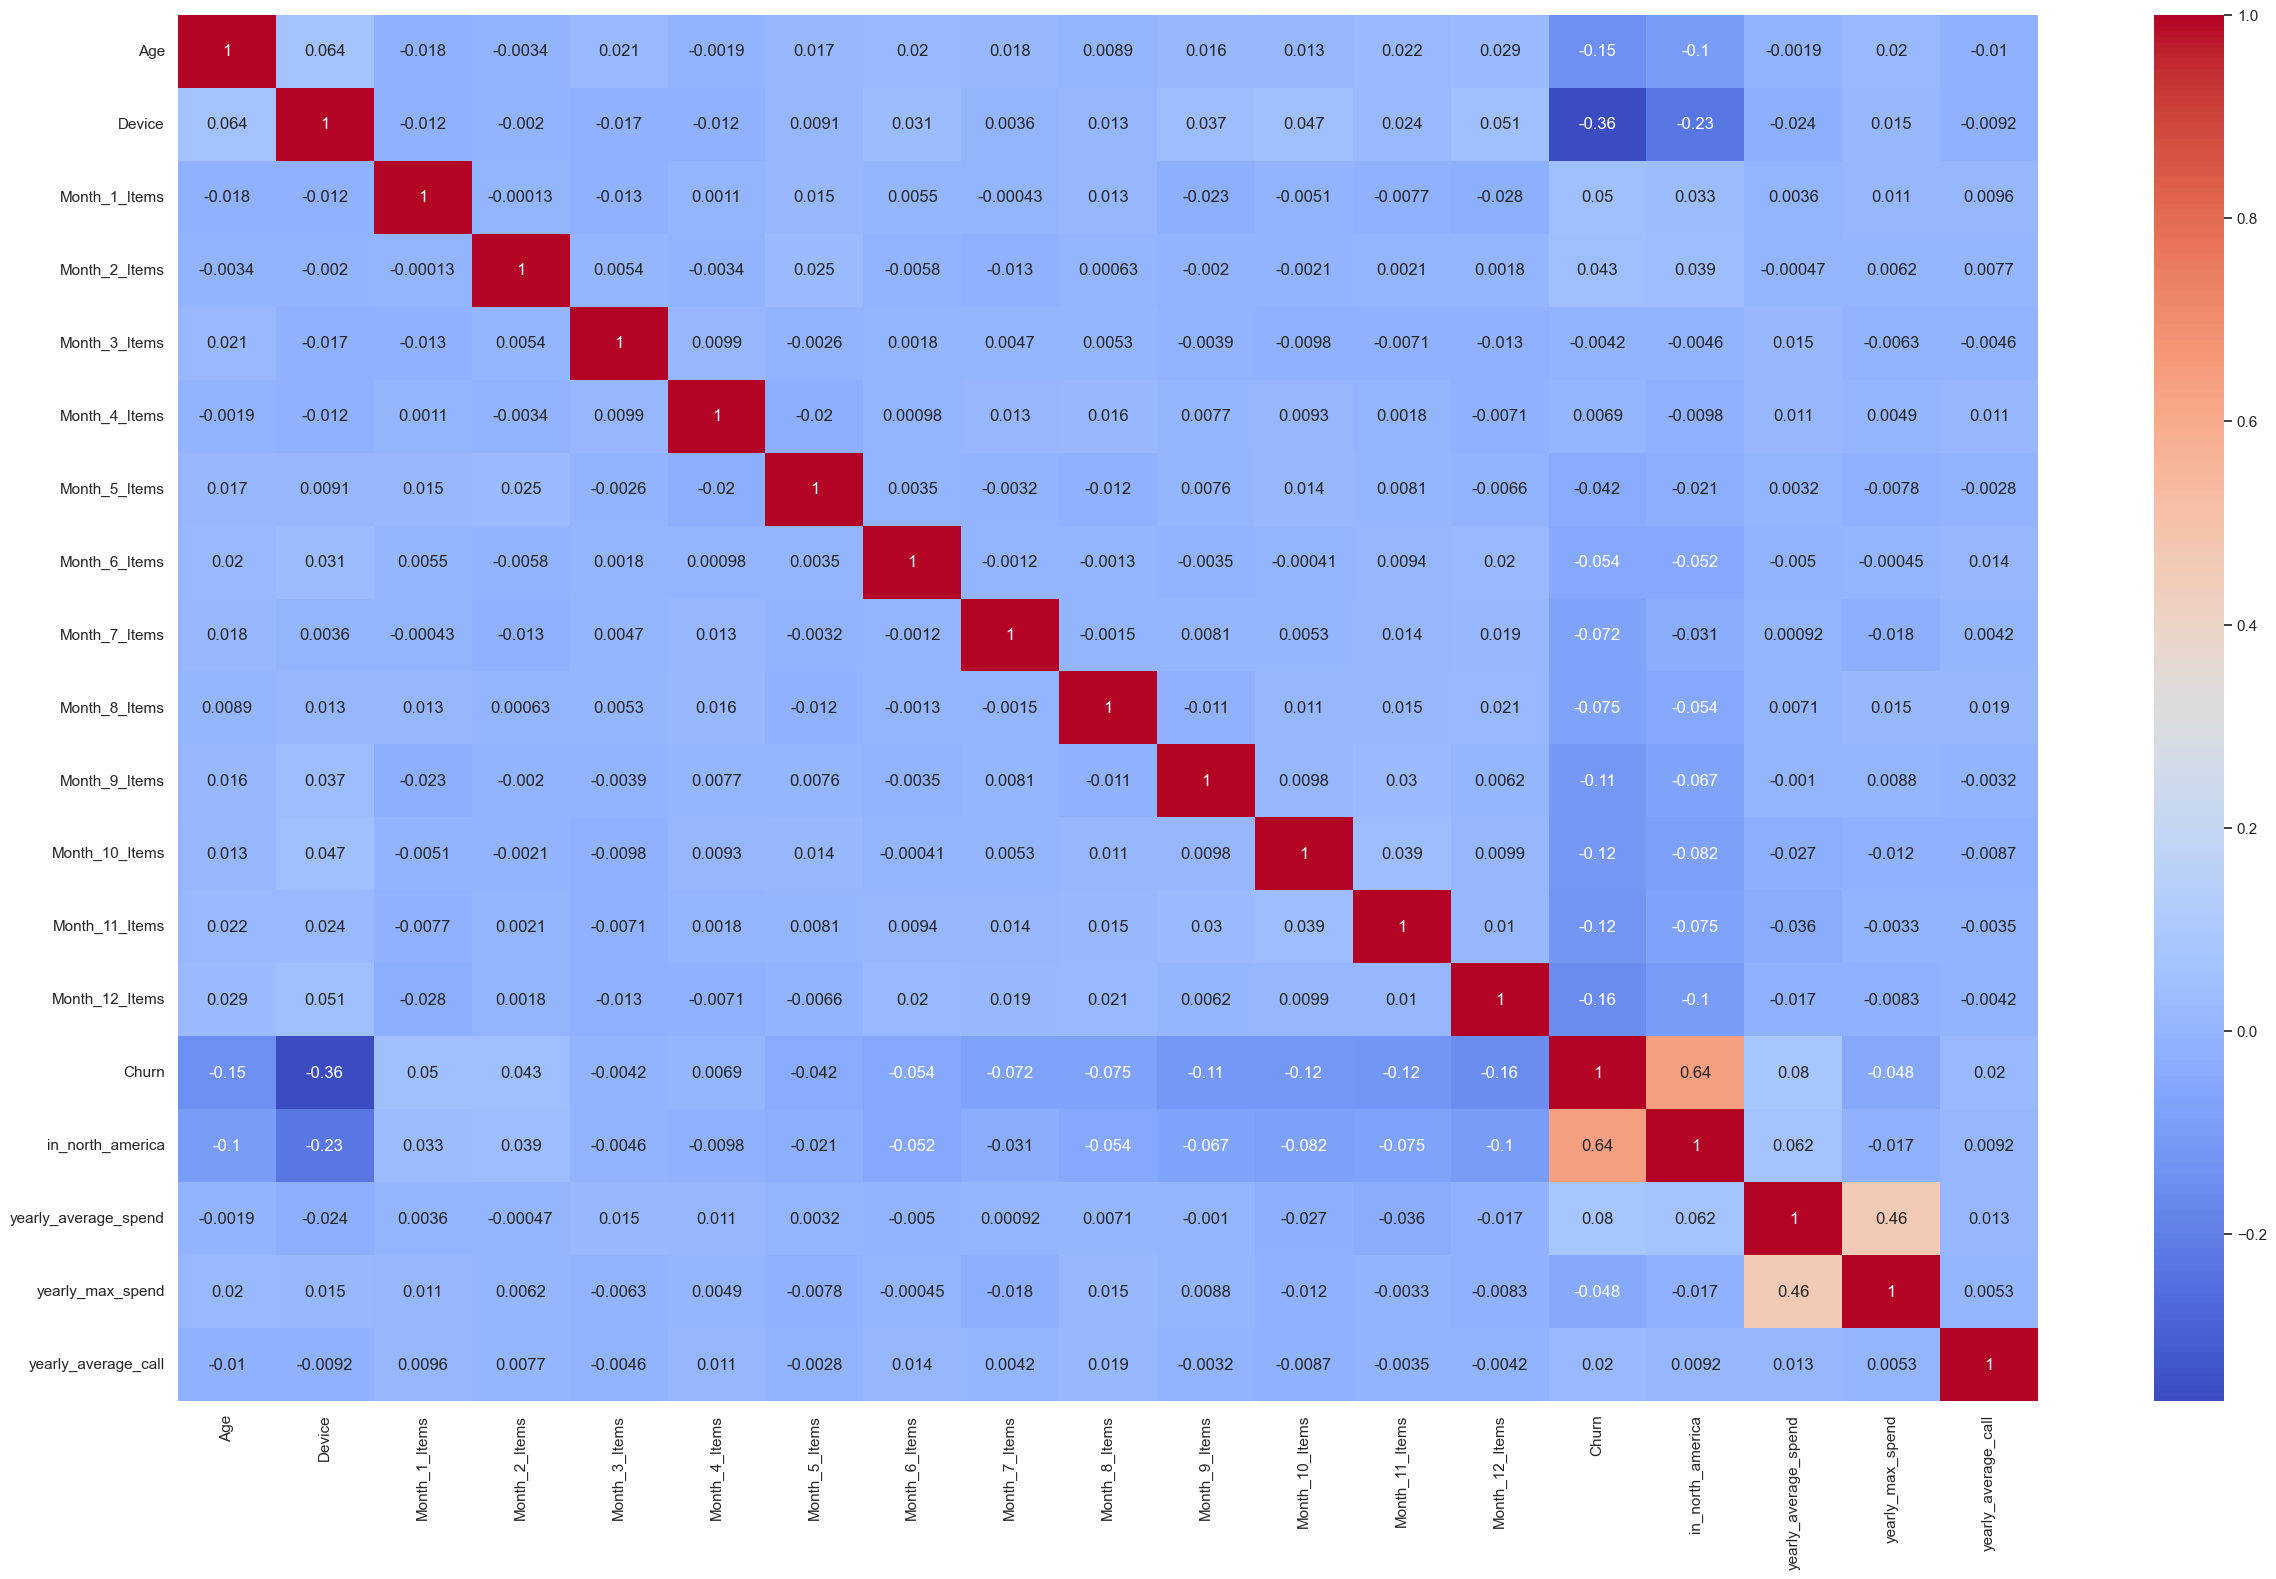

In [76]:
# Correlation matrix heatmap
sns.set(rc={'figure.figsize':(30,18)})
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

The above correlation matrix support our previous conclusion: locations affects the churn, and the churn is also related to the user device

Now let's train a random forest to see the feature importance

Note that **all the training data are used in training the random forest model** to generate the feature importance, because using the entire dataset can provide the most comprehensive view of the data and its inherent patterns. In other words, by leveraging all the available information, we can ensure that the feature importances reflect more accurate representations of how each feature impacts the model's decision-making process. 

And the reason of choosing random forest over logistic regression is that normalization and standardization is not applied at this stage. SInce the features are on different scales, their corresponding coefficients in the logistic regression model are not directly comparable in terms of magnitude. 

In [78]:
X = df[['Age', 'Device', 'Month_1_Items', 'Month_2_Items', 'Month_3_Items',
       'Month_4_Items', 'Month_5_Items', 'Month_6_Items', 'Month_7_Items',
       'Month_8_Items', 'Month_9_Items', 'Month_10_Items', 'Month_11_Items',
       'Month_12_Items','in_north_america', 'yearly_average_spend',
       'yearly_max_spend', 'yearly_average_call']]
y = df['Churn']

In [79]:
rf = RandomForestClassifier(n_estimators = 50,
                            min_samples_split = 5,
                            max_depth=6, 
                            random_state = 12) # avoid overfitting
rf.fit(X, y)

pred = rf.predict(X)

print("accuracy score: ", accuracy_score(pred,y))
print("f1 score: ", f1_score(pred,y))
print("precision score: ", precision_score(pred,y))
print("recall score: ", recall_score(pred,y))
print("roc auc score: ", roc_auc_score(pred,y))

accuracy score:  0.9416
f1 score:  0.9599561162918268
precision score:  1.0
recall score:  0.9229957805907173
roc auc score:  0.9614978902953586


Since the random forest model performs well, we can have confidence that the feature importances it provides are meaningful. The model has learned the underlying patterns in the data, and the features that it deems important are likely to be genuinely relevant to the target variable.

The feature importance are shown below

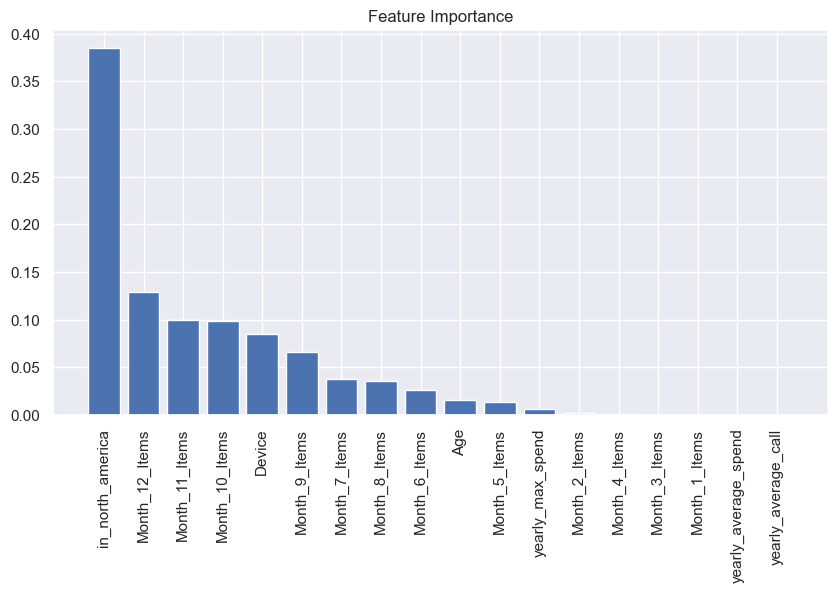

,0
in_north_america,0.384827
Month_12_Items,0.129149
Month_11_Items,0.099144
Month_10_Items,0.098938
Device,0.084949
Month_9_Items,0.066003
Month_7_Items,0.037250
Month_8_Items,0.035235
Month_6_Items,0.025946
Age,0.015439


In [82]:
# visualize results

# get the feature importance
importances = rf.feature_importances_
feature_names = X.columns

# Sort feature importances in descending order and get their indices
indices = np.argsort(importances)[::-1]
sorted_feature_names = [feature_names[i] for i in indices]

plt.figure(figsize=(10, 5))
plt.title("Feature Importance")
plt.bar(sorted_feature_names, importances[indices])
plt.xticks(sorted_feature_names, rotation=90)

plt.show()
pd.DataFrame(importances[indices],index=sorted_feature_names)

Interestingly, the yearly support call and yearly spend seems not related to the churn rate at all due to its small feature importance, while the 'location' has a dominant influence in the result due to its high importance. Hence, we can further conclude that **the churn is abnormal and it may related to the items we sold in North America since month 6 in this year as they have high feature importance in this case**

# Model Training, Tuning, and Evaluation


In [83]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1234)

Let's train a logistic regression as the baseline model without tuning it

In [86]:
import warnings
warnings.filterwarnings("ignore")

In [87]:
log = LogisticRegression()
log.fit(x_train, y_train)

pred = log.predict(x_test)

print('testing result:')
print("accuracy score: ", accuracy_score(pred,y_test))
print("f1 score: ", f1_score(pred,y_test))
print("precision score: ", precision_score(pred,y_test))
print("recall score: ", recall_score(pred,y_test))
print("roc auc score: ", roc_auc_score(pred,y_test))

testing result:
accuracy score:  0.8515
f1 score:  0.8987384930105695
precision score:  0.9229691876750701
recall score:  0.8757475083056478
roc auc score:  0.8267626430417129


The baseline model performance is not bad, with testing f1 score being around 90%, and roc auc score being 82%. Meaning that the baseline model is abour 80% reliable or confident to predict if a customer will churn last month or not

let try other models without tuning for now

In [89]:
knn = KNeighborsClassifier()
nb = GaussianNB()
svc = SVC(kernel='linear')

knn.fit(x_train, y_train)
nb.fit(x_train, y_train)
svc.fit(x_train, y_train)


SVC(kernel='linear')

In [95]:
pred = knn.predict(x_test.to_numpy())
print('knn testing result:')
print("accuracy score: ", accuracy_score(pred,y_test))
print("f1 score: ", f1_score(pred,y_test))
print("precision score: ", precision_score(pred,y_test))
print("recall score: ", recall_score(pred,y_test))
print("roc auc score: ", roc_auc_score(pred,y_test))

knn testing result:
accuracy score:  0.715
f1 score:  0.8270631067961165
precision score:  0.9544817927170869
recall score:  0.7296573875802997
roc auc score:  0.6186165725780287


In [98]:
pred = nb.predict(x_test)
print('naive bayes testing result:')
print("accuracy score: ", accuracy_score(pred,y_test))
print("f1 score: ", f1_score(pred,y_test))
print("precision score: ", precision_score(pred,y_test))
print("recall score: ", recall_score(pred,y_test))
print("roc auc score: ", roc_auc_score(pred,y_test))

naive bayes testing result:
accuracy score:  0.8615
f1 score:  0.9115863389722312
precision score:  1.0
recall score:  0.8375366568914956
roc auc score:  0.9187683284457477


In [99]:
pred = svc.predict(x_test)
print('SVM testing result:')
print("accuracy score: ", accuracy_score(pred,y_test))
print("f1 score: ", f1_score(pred,y_test))
print("precision score: ", precision_score(pred,y_test))
print("recall score: ", recall_score(pred,y_test))
print("roc auc score: ", roc_auc_score(pred,y_test))

SVM testing result:
accuracy score:  0.87
f1 score:  0.9150326797385621
precision score:  0.9803921568627451
recall score:  0.8578431372549019
roc auc score:  0.8908780903665815


Overall, both svc and nb perform similarily, with both f1 score and roc score around 90%, outperforming the baseline model. However, the knn performs relatively poorly (with f1 score being 82% and roc score being 62%), which is worse than the baseline model (logistic regression). So we will tune these 2 models and one extra capable model, xgboost, due to its robustness and accuracy (also, this tree-based model does not require for data standardization, and I choose to not to perform the data standardization as the unstandardized data already gives good model performance. However, this may also explains why the knn model performs poorly as I have not standardized data and the distance-based model is sensitive to different feature scales)

SVM

In [101]:
# Define the hyperparameter configuration spaces
svm_params = { # the range of hyper-parameters we want to search
    'C': np.arange(0.5, 10, 0.5).tolist(),       
    'kernel':['linear','poly', 'rbf', 'sigmoid'],
    'gamma': ['auto','scale'],
    'degree': range(3,10), # set degree for poly kernel use only, the default value is 3
    'coef0': range(0,10), #  only used in ‘poly’ and ‘sigmoid’, default value is 0,
    'tol': [1e-4,1e-3], # default value is 1e-3
    'decision_function_shape': ['ovr','ovo'], # default value is 'ovr', and 'ovo' cannot be used when is 'break_ties=True'
    'probability': [True, False],
    'shrinking': [True, False],
#    'classifier__break_ties': [True, False], # This parameter can only be 'True' when decision_function_shape='ovr', so the default value is 'False'. However, tuning this parameter is redundant as 'False' turns out to be the best parameter setting for 'break_ties'
    'cache_size': [200,300], # Specify the size of the kernel cache size (MB), the default value is 200
}

# SVM model
svm = SVC(max_iter=5000) # set max_iter=5000 to avoid infinite looping
svm_search = RandomizedSearchCV(svm, svm_params, cv=5, scoring = 'f1', n_iter = 10)
svm_search.fit(x_train, y_train)

print('best training score {}'.format(svm_search.best_score_))

best training score 0.8471613436967269


In [102]:
# see the best hyper-parameter
svm_search.best_params_

{'tol': 0.001,
 'shrinking': True,
 'probability': True,
 'kernel': 'poly',
 'gamma': 'scale',
 'degree': 8,
 'decision_function_shape': 'ovr',
 'coef0': 0,
 'cache_size': 300,
 'C': 1.0}

In [109]:
pred = svm_search.best_estimator_.predict(x_test)
print('SVM testing result:')
print("accuracy score: ", accuracy_score(pred,y_test))
print("f1 score: ", f1_score(pred,y_test))
print("precision score: ", precision_score(pred,y_test))
print("recall score: ", recall_score(pred,y_test))
print("roc auc score: ", roc_auc_score(pred,y_test))

SVM testing result:
accuracy score:  0.7725
f1 score:  0.8604722477767556
precision score:  0.9824929971988795
recall score:  0.7654118930714675
roc auc score:  0.8078556471345362


What?! SVM Peformed even worse after tunning, better to stay with default setting then

In [106]:
params_nb = {'var_smoothing': np.logspace(0,-9, num=100)}
randomsearch_nb = RandomizedSearchCV(nb, params_nb, cv=10,scoring='roc_auc')
randomsearch_nb.fit(x_train, y_train)
print("Best parameters for KNN: ", randomsearch_nb.best_params_)


Best parameters for KNN:  {'var_smoothing': 1e-05}


In [ ]:
pred = randomsearch_nb.best_estimator_.predict(x_test)
print('Naive Bayes testing result:')
print("accuracy score: ", accuracy_score(pred,y_test))
print("f1 score: ", f1_score(pred,y_test))
print("precision score: ", precision_score(pred,y_test))
print("recall score: ", recall_score(pred,y_test))
print("roc auc score: ", roc_auc_score(pred,y_test))

SVM testing result:
accuracy score:  0.881
f1 score:  0.9227774172615184
precision score:  0.9957983193277311
recall score:  0.8597339782345829
roc auc score:  0.9211964688860775


Slight improvement on f1 score and roc score by 1%, reaching 92%, which should be sufficiently reliable and accurate

In [110]:
from xgboost import XGBClassifier

xgb_params =  {
    'learning_rate':np.arange(0,2,0.05),
    'n_estimators': range(50,1000, 50),
    'max_depth': range(10,500,20),
    'min_child_weight': range(1,5),
    'gamma': np.arange(0.01,0.3, 0.01),
    'objective': ['binary:hinge'], # binary classification
    'booster': ['gbtree', 'gblinear', 'dart']
}

# XGBoost model
xgb = XGBClassifier()
xgb_search = RandomizedSearchCV(xgb, xgb_params, cv=5, scoring = 'f1', n_iter = 10)
xgb_search.fit(x_train, y_train)

print('best training score {}'.format(xgb_search.best_score_))

[21:57:51] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "gamma", "max_depth", "min_child_weight" } are not used.

[21:57:51] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "gamma", "max_depth", "min_child_weight" } are not used.

[21:57:51] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "gamma", "max_depth", "min_child_weight" } are not used.

[21:57:51] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "gamma", "max_depth", "min_child_weight" } are not used.

[21:57:52] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.c

KeyboardInterrupt: 

In [ ]:
# see the best hyper-parameter
xgb_search.best_params_

In [ ]:
pred = xgb_search.best_estimator_.predict(x_test)
print('SVM testing result:')
print("accuracy score: ", accuracy_score(pred,y_test))
print("f1 score: ", f1_score(pred,y_test))
print("precision score: ", precision_score(pred,y_test))
print("recall score: ", recall_score(pred,y_test))
print("roc auc score: ", roc_auc_score(pred,y_test))

No time to complete the training unfortunately due to the time limit

Xgboost

# Summary to a business executive (But I will recommend to read through my notebook as detailed comments are all around the important figures and operations)

    Key data exploration findings, initial hypothesis, and whether the hypothesis proved true:

A: Age, Location, Device are important to determine if a customer have churned or not, while user spend and support calls are not that important and can be combined together as they do not differ from month to month in a year
   
  
    Overall approach for building and evaluating the model:

A: Detailed feature engineering and feature selection can be referred on above notebook. Most evaluation metrics are applied such as accuracy score, f1 score, precision, recall, and roc auc score, while we will primarily assess the model performance on f1 and roc score
    
    The final model selected and why this is the best model for the problem:

A: The final model selected is naive bayes if we want to fast and efficient model training, while if we have sufficient computationally resources and time, we will rely on the xgboosting as it gives a better performance but take a long time. The reason for why bayes is better can be due to the reason that the churn pattern in this case is intuitive (i.e. Android user more likely to churn, and north america users are more likely to churn) and can be well-captured by a simple probabilitic model

    How the model should be used by the business in the business process:
A:  The model can be deployed at the beginning of every month to predict the likelihood of certain users to churn, and retrained on the new monthly data at the end of the month to keep the model updated.
 